# Single analyser of Model1 on multiple images using iNNvestigate

## Circular shapes with same radius

This notebook shows how saliency maps are computed for a single method (gradient) on many images from the Shape Images dataset.

(It is based on the **iNNvestigate** notebook: [Introduciton](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/introduction.ipynb))

## Imports

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')
import imp
import numpy as np
import os

import keras
import keras.backend
from keras.utils import np_utils

import innvestigate
import innvestigate.utils as iutils
mnistutils = imp.load_source("utils_mnist", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils_mnist.py")

from CNNcount import shape_images as si
import numpy as np
import matplotlib.pyplot as plt
from numpy import load
import os.path


Using TensorFlow backend.


## Data
Load the dataset and select the test set for analysis.

The file containing images of the same shape (circle) with same radius already exist!
Size of test data:  (6000, 64, 64, 1) and labels:  (6000,)


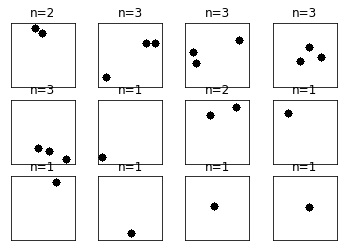

In [3]:
# input image dimensions and number of classes
img_rows, img_cols = 64, 64
num_classes = 3

# filename for loading the data from the NPZ files (NumPy compressed)
same_shape_same_radius_fname = "/home/elena/eStep/XAI/Data/CountingShapes/circles_same_radius_60k.npz"

# load the set of images with the same type and same radius and split the test subset
if os.path.isfile(same_shape_same_radius_fname): # already generated- just load
    print ("The file containing images of the same shape (circle) with same radius already exist!")
    # load from NPZ file for display
    _, _, images_test, _, _, labels_test = si.load_split_data(same_shape_same_radius_fname)
    
    
    if keras.backend.image_data_format() == 'channels_first':
        images_test = images_test.reshape(images_test.shape[0], 1, img_rows, img_cols)
    print("Size of test data: ", np.shape(images_test), "and labels: ", np.shape(labels_test))
else: # missing data
    print ("The file containing images of the same shape (circle) with same radius does not exist!")
    print("Use the GenerateShapeImages notebook to generate the experimental data.") 
    
# plot random 12 of the train images
si.plot_12images(images_test, labels_test)

## Model
The next part evaluates the pretrained CNN.

In [4]:
# imports
from CNNcount import model_count_shapes as mcs
# filename for model saving
same_shape_same_radius_model_fname = "/home/elena/eStep/XAI/Data/CountingShapes/model_circles_same_radius.h5"
# load the trained model
from keras.models import load_model
model = load_model(same_shape_same_radius_model_fname) 
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Loaded model from disk


Formatting of the labels

In [5]:
# convert class vectors to binary class matrices
numerical_labels_test = labels_test
labels_test = np_utils.to_categorical(numerical_labels_test-1, num_classes=None)
print(labels_test)
print('labels_test shape:', labels_test.shape)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
labels_test shape: (6000, 3)


Evaluate on test images.

In [6]:
score = model.evaluate(images_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.00011350703237500663
Test accuracy: 1.0


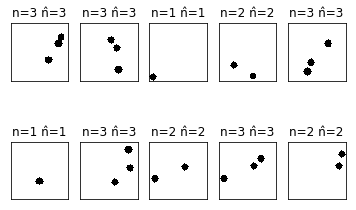

In [7]:
# generate 10 random images and predict the number of shapes using the trained model
for i in range(10):
    n = int(np.random.randint(1, 3+1))
    shapes = [(0, 4) for _ in range(n)]
    img = si.generate_image(64, shapes, 0)    
    
    X = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
    plt.subplot(2, 5, i+1)
    plt.imshow(img,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    predictions = model.predict(X);
    #print(predictions)
    pred = np.argmax(predictions) + 1 # we subtracted 1 before
    #print(pred)
    plt.title('n=%d n̂=%d' % (n, pred))

plt.show()

## Analysis

Chose 10 random test images to generate a heatmap for. Create a gradient * input analyzer.
Pass the model without a softmax to the analyzer class:

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


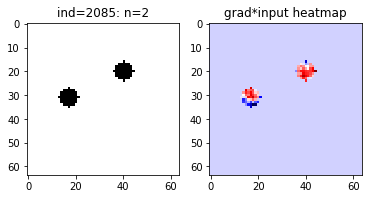

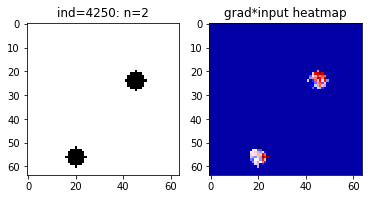

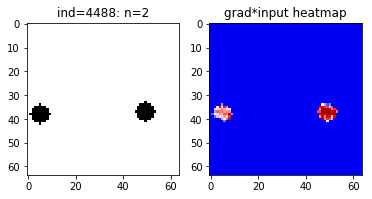

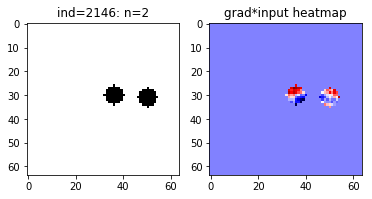

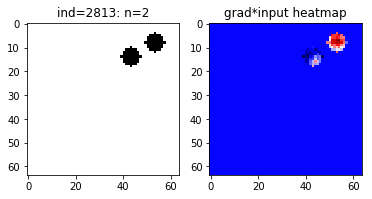

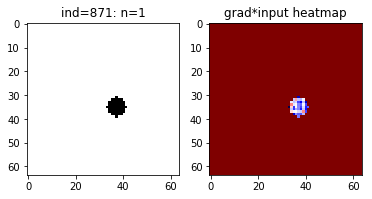

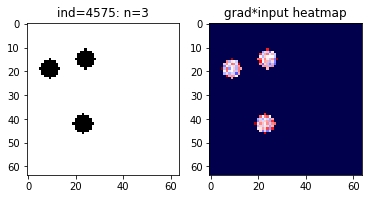

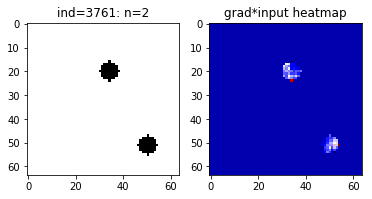

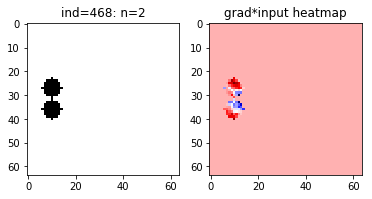

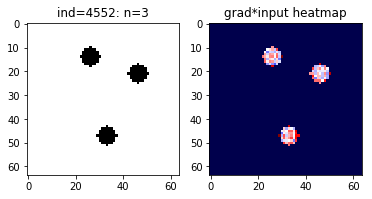

In [8]:
nim = len(labels_test)

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Creating an analyzer
inputXgradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model_wo_sm)

for _ in range(10):
    ind=int(np.random.randint(1,nim))
    img=images_test[ind,:,:]
    img=np.reshape(img,(64,64))
    label=numerical_labels_test[ind]
    # display the image
    plt.subplot(1,2,1)
    plt.imshow(img,cmap='binary')
    plt.title('ind=%d: n=%d' % (ind,label))
    
    # Applying the analyzer
    image = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
    analysis = inputXgradient_analyzer.analyze(image)

    # Displaying the gradient
    plt.subplot(1,2,2)
    plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
    plt.title('grad*input heatmap')
    
    plt.show()